# EE4312 Lab 1 *Regression*
Due Date: 14 Feb 2025 (W5 Fri), 23:59

---
# 1 $\quad$ Introduction
Regression is all about finding a quantitative output $y$ from an input variable $x$. A regression problem focuses on using a neural network to approximate the relationship between $y(x)$ and $x$, which is learnt from noisy sampled data $\tilde{y}(x)$.

In this lab, the output $y$ is the response of a system that is randomized based on your matric number. 71 noisy measurements were made for $x\in[0,7]$. The task is to build a 1-layer neural network with Keras, and approximate the response.

## 1.1 $\quad$ Initialization
1. Replace the string in `matric_numbers` with your matric number.
2. Run the code block (`Ctrl+Enter`).

c:\Users\johna\anaconda3\envs\fyp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  Seed: 233403
tau: 0.7260698292176594


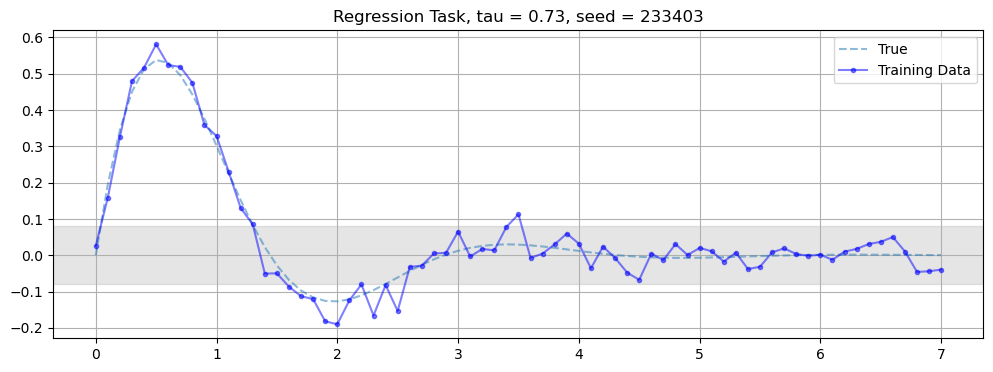

In [1]:
matric_numbers = ['A0233403W']

######### Import libraries ###################
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import keras
from tqdm.keras import TqdmCallback
# from google.colab import files
import os
import shutil

########## Code to make training reproducible ##########
def makeSeed(matric_numbers):
  seed = 0;
  for i in range(len(matric_numbers)):
    seed += int(''.join(filter(str.isdigit, matric_numbers[i])))
  print(f'  Seed: {seed}')
  return seed

SEED = makeSeed(matric_numbers)

def makeReproducible():
  tf.keras.utils.set_random_seed(SEED)
  tf.config.experimental.enable_op_determinism()

########### Create Folders to store trained data #############
R_FOLDER = 'data/lab1'

shutil.rmtree(R_FOLDER, ignore_errors=True)
os.makedirs(R_FOLDER, exist_ok=True)

# !rm -rf $R_FOLDER # removes the folder. this is not a valid python script, used only in colab
# !mkdir -p $R_FOLDER # this is not a valid python script, used only in colab

###### Define Constants #####
R_MIN_TEST_X = 0
R_MIN_TRAIN_X = 0
R_MAX_TRAIN_X = 7
R_MAX_TEST_X = 7
R_NUM_POINTS = 71

###### Variables to be initialized later, placed here for clarity ##########
r_model = None
r_expt_name = ''
r_num_hidden = 0
r_learning_rate = 0
r_epochs = 0
r_batch_size = 0
r_elapsed = 0
r_history = None
r_train_indices = None
r_x_test = []
r_y_test = [] # the true y over the domain of x_test
r_x_train = [] # the x data, that has a smaller domain than x_test
r_y_train = [] # the noisy y over the domain of x_train
r_y_pred = []
r_tau = 0

##### Initialize the variables ########
def rInit():
  r_tau = np.random.uniform(0.7, 0.8) if np.random.uniform() > 0.5 else np.random.uniform(1.1, 1.3)
  print(f'tau: {r_tau}')
  r_x_test = np.linspace(R_MIN_TEST_X, R_MAX_TEST_X, R_NUM_POINTS).reshape(-1, 1)
  r_y_test = np.sin(r_x_test * r_tau * 3) * np.exp(r_x_test *-1)
  r_train_indices = (r_x_test >= R_MIN_TRAIN_X) & (r_x_test <= R_MAX_TRAIN_X)
  r_train_indices = np.array(r_train_indices).reshape(-1)
  r_x_train = r_x_test[r_train_indices]
  r_y_train = r_y_test[r_train_indices]
  r_y_train = r_y_train + np.random.normal(0.0, 0.03, r_y_train.shape)
  return r_tau, r_train_indices, r_x_test, r_y_test, r_x_train, r_y_train

##### Plot the Regression Task #######
def rPlotTask():
  fig, ax = plt.subplots()
  ax.axhspan(-0.08, 0.08, alpha=0.2, color='grey') # steady state
  ax.plot(r_x_test, r_y_test, '--', alpha=0.5, label='True')
  ax.plot(r_x_train, r_y_train, 'b.-', alpha=0.5, label='Training Data')
  ax.grid(True, which='both', axis='both')
  ax.legend();
  ax.set_title(f'Regression Task, tau = {r_tau:.2f}, seed = {SEED}')
  ax.grid(visible=True)
  fig.set_size_inches(12.0, 4.0)
  fig.savefig(f'{R_FOLDER}/task.png', dpi=100)

##### Run the functions ##########
makeReproducible() # call this everytime to 'reset' the random number generator and make subsequent random calls reproducible.
r_tau, r_train_indices, r_x_test, r_y_test, r_x_train, r_y_train = rInit()
rPlotTask()

## 1.2 $\quad$ Ignore Oscillations at Steady State
The response is considered to be at steady state at $x=d$ if $|y(x)|$ is expected to be smaller than $0.08$ for all $x \ge d$. The values of $y$ satisfying the criterion is depicted as the gray region in the plot above.

Take note that if $y(x)$ is expected to be in steady state after $x=d$, any **oscillations after $x=d$ can be ignored** when designing the neural network.

---
# 2$\quad$ Code the Regression Model

## 2.1 $\quad$ Function that Builds the Model

Specify the design of the neural network in `r_model`, which will be returned by the function `rBuildModel()`.

1. **Initialize the layers**. The input layer, a hidden layer, and an output layer is required. For the hidden layer, use the variable `r_num_hidden` to specify the number of hidden neurons.
  ```python
  input_layer = keras.Input(shape=??) # ?? is tuple specifying the input dimensions.
  hidden_layer = keras.layers.Dense(??, activation=????) # ?? is the number of neurons. # ???? is a string specifying the activation function
  output_layer = keras.layers.Dense(??, activation=????) # ?? is the number of neurons. # ???? is a string specifying the activation function
  ```
2. **Link the layers** by calling the layer variables (i.e. using `()`) with their previous layer. e.g.
  ```python
  output_layer = output_layer(hidden_layer(input_layer))
  ```
3. **Initialize the model** `r_model` with the linked layers:
  ```python
  r_model = keras.Model(inputs=[input_layer], outputs=[output_layer], name='Regression')
  ```
4. **Compile the model** with the selected loss and optimizer:
  ```python
  sgd = keras.optimizers.SGD(learning_rate=r_learning_rate)
  r_model.compile(loss='??', optimizer=sgd) # ?? is the name of the loss used in regression.
  ```
  *You may notice that the loss can be specified using `keras.losses.???` instead of a string, and similarly for the optimizer. Either way (string or Keras object) is acceptable.*
5. Next, print a summary of the model to the output using
  ```python
  r_model.summary()
  ```
6. The model is then returned by the function. **Run** the cell block to register the function into the workspace, and fix any syntax errors that show up.  *Note the function will not run for now. Further errors will only be discovered later when we run this function and the subsequent functions in a later code cell.*



In [8]:
def rBuildModel():
  ###### Specify the layers #####
  # (1)
  input_layer = keras.Input(shape=(1,)) #because it is from x = [0,7]
  hidden_layer = keras.layers.Dense(r_num_hidden, activation='tanh')
  output_layer = keras.layers.Dense(1, activation='linear')

  ###### Link the layers #####
  # (2)
  output_layer = output_layer(hidden_layer(input_layer))

  ###### Initialize model #####
  # (3)
  r_model = keras.Model(inputs=[input_layer], outputs=[output_layer], name='Regression')

  ###### Compile model #####
  # (4)
  sgd = keras.optimizers.SGD(learning_rate=r_learning_rate)
  r_model.compile(loss='mse', optimizer=sgd)

  ###### Summarize #####
  # (5)
  r_model.summary()


  print(f'----------------------------------')
  return r_model

## 2.2 $\quad$ Function that Trains the Model
The code to train the model is defined in the function `rTrainModel()`.

1. In the function, the `.fit()` method is used to train the model `r_model`:
```python
r_history = r_model.fit(???, # the x samples used for training.
                        ???, # the y samples used for training.
                        shuffle=True,
                        batch_size=???, # the batch size.
                        epochs=???, # the number of epochs.
                        validation_split=0,
                        verbose=0,
                        callbacks=[TqdmCallback(verbose=0)],
                        ) # this is a single line-command split over multiple lines for readability.
```
  The code above requires:
  - The input $x$ samples stored in `r_x_train`.
  - The measured $\tilde{y}$ samples stored in `r_y_train`.
  - The batch size stored in `r_batch_size`.
  - The number of epochs to train in `r_epochs`.

  `r_history` stores information about the training. `r_elapsed` is the time taken to train the model in seconds. `r_model` will contain the trained weights and can be used to predict an input layer. The three variables are returned by the function.

2. **Run** the code block to register the function and fix any errors.

In [3]:
def rTrainModel():
  ########### Train the Model #########
  print(f'    Experiment: {r_expt_name}\nHidden Neurons: {r_num_hidden}\n Learning Rate: {r_learning_rate}\n        Epochs: {r_epochs}\n    Batch Size: {r_batch_size}')
  r_elapsed = time.time()

  # (1)
  r_history = r_model.fit(r_x_train, r_y_train, shuffle=True, batch_size=r_batch_size, epochs=r_epochs, validation_split=0, verbose=0, callbacks=[TqdmCallback(verbose=0)])

  r_elapsed = time.time() - r_elapsed

  ########### Save the model ###########
  r_model.save(f'{R_FOLDER}/{r_expt_name}.keras')
  print(f'Trained Model saved to {R_FOLDER}/{r_expt_name}.keras')

  return r_model, r_history, r_elapsed

## 2.3 $\quad$ Function that Predicts using Trained Model
The code to find the predicted output $\tilde{y}$ with the trained model is designed in the function `rPredictModel()`.

1. The method `.predict()` is used to predict the output from the trained model `r_model`:
```python
  ?? = r_model.predict(????) # ?? is the predicted output. ???? is the input used to predict the output.
```
  In this implementation, the output is predicted over the domain of the training data:
  - The trained input $x$ is stored in `r_x_train`.
  - The predicted output $\tilde{y}$ must be stored in `r_y_pred`, which is returned by the function
2. **Run** the code block to register the function and fix any errors.


In [4]:
def rPredictModel():
  # (1)
  r_y_pred = r_model.predict(r_x_train)

  return r_y_pred

## 2.4 $\quad$ Function that Analyzes the Trained Model
The function `rAnalyzeModel()` saves performance-related data, trained weights, and hyperparameters in a text file, and visualizes them.

1. When `rTrainModel()` is run, the loss that is displayed in the output refers to the **moving average calculated over multiple batches**. Instead, we are intersted in the loss that is calculated instead over the **entire** measured output $\tilde{y}$ and true output $y$:
```python
loss = keras.losses.??() # ?? is a function, not a string, of the loss used above.
train_loss = loss(??, ????) # ?? is the measured output, ???? is the predicted output
test_loss = loss(??, ????) # ?? is the true output, ???? is the predicted output
```
  - The true output $y$ is stored in `r_y_test`.
  - The predicted output $\hat{y}$ is stored in `r_y_pred`.
  - The measured output $\tilde{y}$ is stored in `r_y_train`.



In [5]:
######### Analyze ###################
def rAnalyzeModel(): # put in function to prevent temporary vars from polluting the workspace
  ########## Calc loss ##############
  # (1)
  loss = keras.losses.MeanSquaredError()
  train_loss = loss(r_y_train, r_y_pred)
  test_loss = loss(r_y_test, r_y_pred)
  ########### Plot Predicted output #############
  # Predicted output is over the larger r_x_test data.
  # training is done over the smaller r_x_train data.
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.axhspan(-0.08, 0.08, alpha=0.2, color='grey') # steady state
  ax.plot(r_x_test, r_y_test, '--', alpha=0.5, label='True')
  ax.plot(r_x_train, r_y_train, 'b.-', alpha=0.5, label='Training Data')
  ax.plot(r_x_test, r_y_pred, color='red', label='Predicted')
  ax.grid(True, which='both', axis='both')
  ax.legend();
  ax.set_title(f'Regression Results ({r_expt_name})')
  ax.grid(visible=True)
  fig.set_size_inches(12.0, 4.0)
  fig.savefig(f'{R_FOLDER}/{r_expt_name}_results.png', dpi=100, bbox_inches='tight')

  ########## Loss Plots #############
  fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
  # MA Loss
  r_history_loss = r_history.history['loss']
  axes[0].plot(r_history_loss)
  axes[0].set_title(f'Moving Average Loss vs. Epoch ({r_expt_name})')
  axes[0].set_ylabel('Moving Average Loss')
  axes[0].set_xlabel('Epoch')
  axes[0].grid(True, which='both', axis='both');
  # Log of MA loss
  axes[1].plot(np.log(r_history_loss))
  axes[1].set_title(f'Log of Moving Average Loss vs. Epoch ({r_expt_name})')
  axes[1].set_ylabel('Log of Moving Average Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].grid(True, which='both', axis='both')
  plt.savefig(f'{R_FOLDER}/{r_expt_name}_loss.png', bbox_inches='tight')

  ########## Find the individual and cumulative contribution of neurons =============
  # Extract weights and simulate responses
  r_l1_weights = r_model.layers[1].get_weights()
  r_l1_w1 = r_l1_weights[0] #w
  r_l1_w0 = r_l1_weights[1] #bias
  # one cell is induced field for each neuron for each sample
  r_y_neuron = np.matmul(r_x_test, r_l1_w1) + r_l1_w0 # Nxnum_hidden
  # activation (output of first layer) of each sample for each neuron
  r_y_neuron = np.tanh(r_y_neuron)

  r_l2_weights = r_model.layers[2].get_weights()
  r_l2_w1 = np.transpose(r_l2_weights[0]) #w (1xnum_hid)
  r_l2_w0 = r_l2_weights[1] #bias
  r_y_neuron = r_y_neuron * r_l2_w1 # Nxnum_hid * 1xnum_hid

  # Show the contribution of each neuron
  fig_nrows = r_num_hidden // 10 + (r_num_hidden % 10 != 0)
  fig, axes = plt.subplots(nrows=fig_nrows, ncols=10, figsize=(20, fig_nrows * 2.0))
  fig.subplots_adjust(top=0.75)
  i = 0
  for ax in fig.axes:
    if i >= r_num_hidden:
      ax.axis('off')
      continue
    ax.plot(r_x_test, r_y_neuron[:, i])
    ax.grid(True, 'both', 'both')
    i += 1
    ax.set_title('$w^{(2)}_{1,%d}y^{(1)}_{%d}$' % (i, i))
  fig.suptitle(f'Individual Contribution of Hidden Neurons ({r_expt_name})', x=0.2, y=0.98)
  plt.savefig(f'{R_FOLDER}/{r_expt_name}_contribution.png', bbox_inches='tight')

  fig, axes = plt.subplots(nrows=fig_nrows, ncols=10, figsize=(20, fig_nrows * 2.3))
  fig.subplots_adjust(top=0.65)
  i = 0
  r_y_neur_cum = np.zeros(r_y_test.shape)
  for ax in fig.axes:
    if i >= r_num_hidden:
      ax.axis('off')
      continue
    r_y_neur_cum[:, 0] += r_y_neuron[:, i]
    ax.plot(r_x_test, r_y_neur_cum)
    ax.grid(True, 'both', 'both')
    i += 1
    ax.set_title('$\sum_{i=1}^{%d} w^{(2)}_{1,i}y^{(1)}_{i}$' % i)
  fig.suptitle(f'Cumulative Contribution of Hidden Neurons ({r_expt_name})', x=0.2, y=0.98)
  plt.savefig(f'{R_FOLDER}/{r_expt_name}_cumulative.png', bbox_inches='tight')

  #### Write to text file ####
  tmp = open(f'{R_FOLDER}/{r_expt_name}.txt', 'w')
  # Print weights
  out = ''
  out += f'Experiment\t{r_expt_name}\n'
  out += f'Hidden Neurons\t{r_num_hidden}\n'
  out += f'Learning Rate\t{r_learning_rate}\n'
  out += f'Epochs\t{r_epochs}\n'
  out += f'Batch\t{r_batch_size}\n'
  out += f'Elapsed(s)\t{r_elapsed}\n'
  for i in range(1, 11):
    out += f'Moving Average Loss ({i}0% Epoch)\t{r_history_loss[int(0.1 * i * len(r_history_loss) - 1)]}\n'
  out += f'Train Loss\t{train_loss}\n'
  out += f'True Loss\t{test_loss}\n'

  out += 'Weights:\n'
  for i in range(r_num_hidden): # first layer
    out += ('w^{(1)}_%d\t%5.2f\t%5.2f\n' % (i + 1, r_l1_w0[i], r_l1_w1[0, i]))
  out += ('w^{(2)}_1\t%5.2f' % r_l2_w0[0])  # output bias
  for i in range(r_num_hidden): # output
    out += '\t%5.2f' % r_l2_w1[0, i]
  out += '\n'

  tmp.write(out)
  tmp.close()
  print(out)

---
# 3 $\quad$ Run the Regression Model

1. Test your code above by running the following. If there are errors:
  1. Go to the function and fix the error.
  2. **Always run** the code block containing the **modified function** to register the modifications.
2. Once all errors are fixed, you may adjust the `experiments` list to run multiple experiments and observe the effects of adjusting the hyperparameters.

====================== START OF EXPT mimimal ====================================
Model: "Regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 4)                 8         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
----------------------------------
    Experiment: mimimal
Hidden Neurons: 4
 Learning Rate: 0.01
        Epochs: 7000
    Batch Size: 10


100%|██████████| 7000/7000 [00:52<00:00, 133.08epoch/s, loss=0.00174]


Trained Model saved to data/lab1/mimimal.keras
3/3 [==============================] - 0s 2ms/step
Experiment	mimimal
Hidden Neurons	4
Learning Rate	0.01
Epochs	7000
Batch	10
Elapsed(s)	52.681920528411865
Moving Average Loss (10% Epoch)	0.013373463414609432
Moving Average Loss (20% Epoch)	0.01165476068854332
Moving Average Loss (30% Epoch)	0.00944987591356039
Moving Average Loss (40% Epoch)	0.006797936279326677
Moving Average Loss (50% Epoch)	0.004416832700371742
Moving Average Loss (60% Epoch)	0.0029123371932655573
Moving Average Loss (70% Epoch)	0.0021712849847972393
Moving Average Loss (80% Epoch)	0.001894329790957272
Moving Average Loss (90% Epoch)	0.0017673096153885126
Moving Average Loss (100% Epoch)	0.001742160296998918
Train Loss	0.0017416375922039151
True Loss	0.0005742081557400525
Weights:
w^{(1)}_1	-0.36	 0.63
w^{(1)}_2	-0.06	 0.71
w^{(1)}_3	-0.16	 1.73
w^{(1)}_4	-1.32	 1.55
w^{(2)}_1	-0.54	 0.60	 0.10	 0.93	-1.07

====================== END OF EXPT mimimal ==================

100%|██████████| 6500/6500 [00:47<00:00, 137.93epoch/s, loss=0.00171]


Trained Model saved to data/lab1/suggested.keras
3/3 [==============================] - 0s 2ms/step
Experiment	suggested
Hidden Neurons	10
Learning Rate	0.01
Epochs	6500
Batch	10
Elapsed(s)	47.176393270492554
Moving Average Loss (10% Epoch)	0.013947096653282642
Moving Average Loss (20% Epoch)	0.013491508550941944
Moving Average Loss (30% Epoch)	0.012663203291594982
Moving Average Loss (40% Epoch)	0.011562935076653957
Moving Average Loss (50% Epoch)	0.009913560003042221
Moving Average Loss (60% Epoch)	0.007047316525131464
Moving Average Loss (70% Epoch)	0.0044963848777115345
Moving Average Loss (80% Epoch)	0.0028125126846134663
Moving Average Loss (90% Epoch)	0.0019222067203372717
Moving Average Loss (100% Epoch)	0.001713551115244627
Train Loss	0.0016293766675516963
True Loss	0.0005677613080479205
Weights:
w^{(1)}_1	-0.33	 0.47
w^{(1)}_2	-0.06	 0.58
w^{(1)}_3	-0.08	 0.62
w^{(1)}_4	-1.27	 1.43
w^{(1)}_5	-0.05	 0.63
w^{(1)}_6	-0.03	-0.07
w^{(1)}_7	-0.09	 0.45
w^{(1)}_8	-0.19	-0.12
w^{(1)}

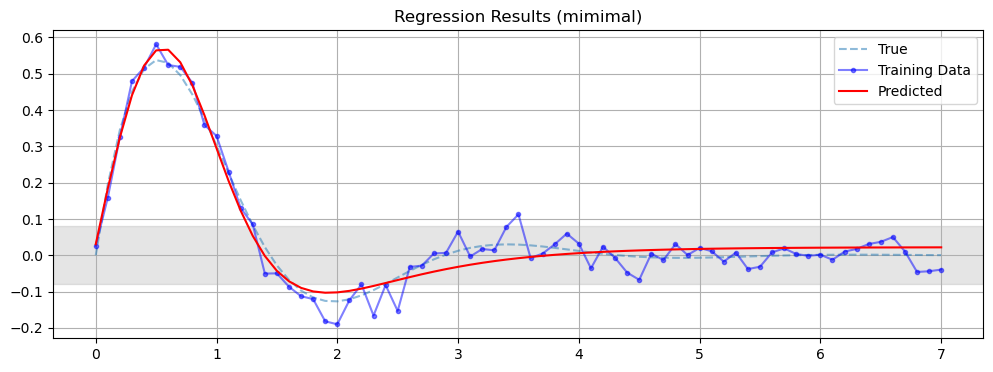

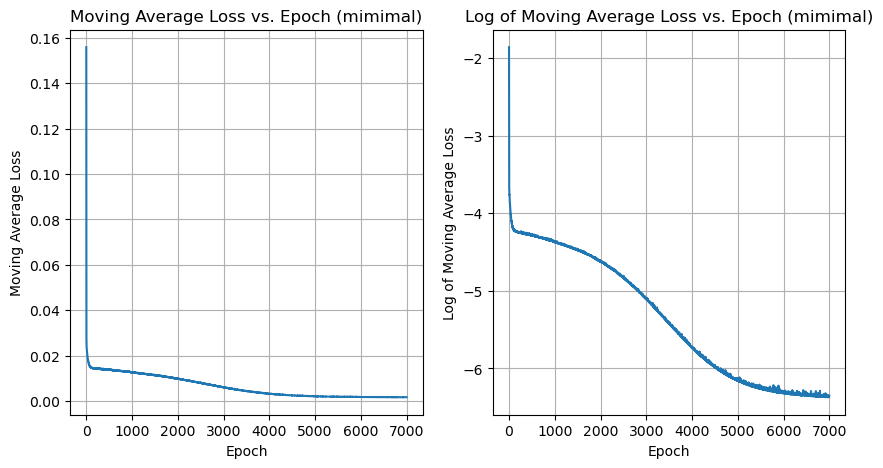

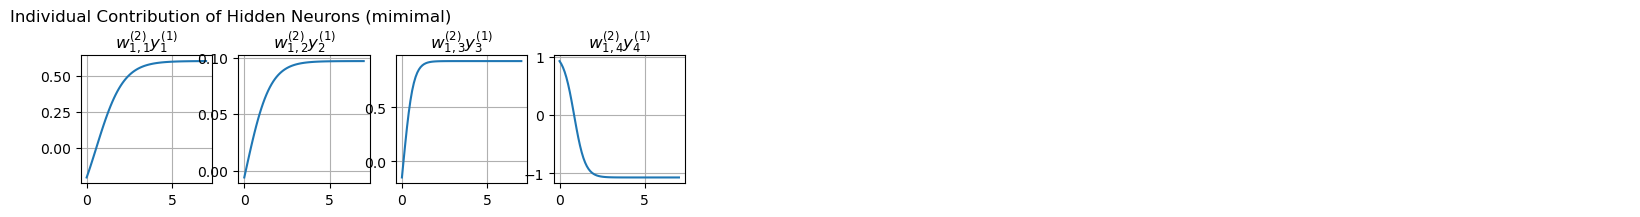

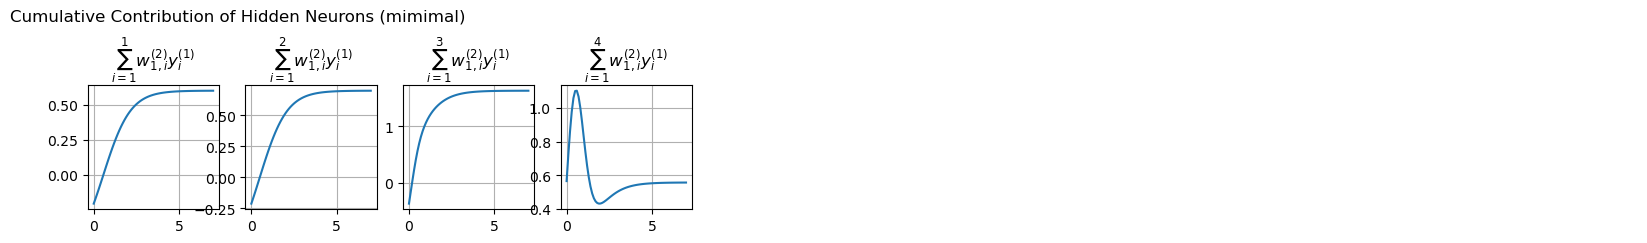

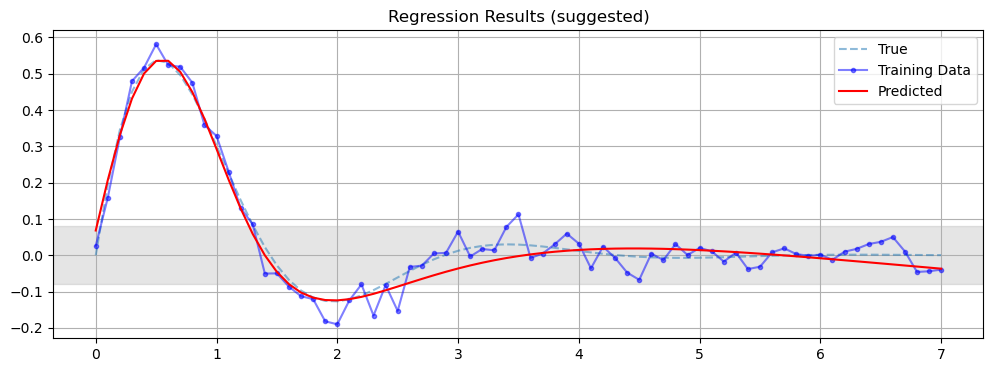

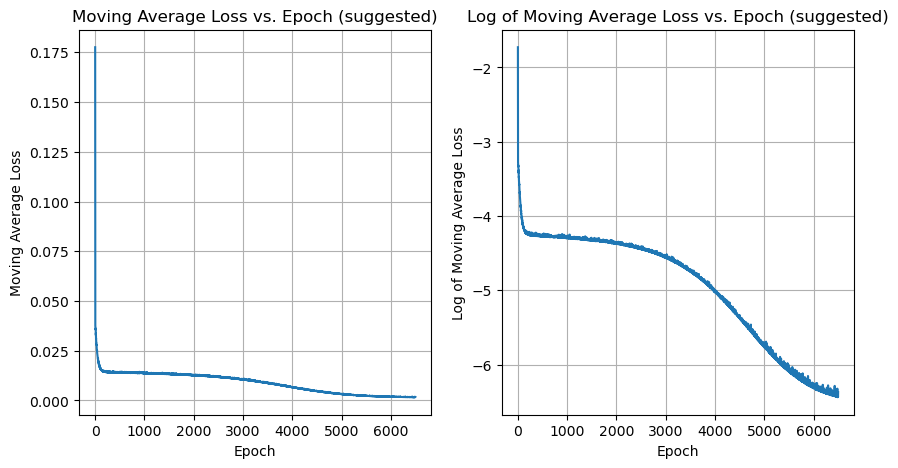

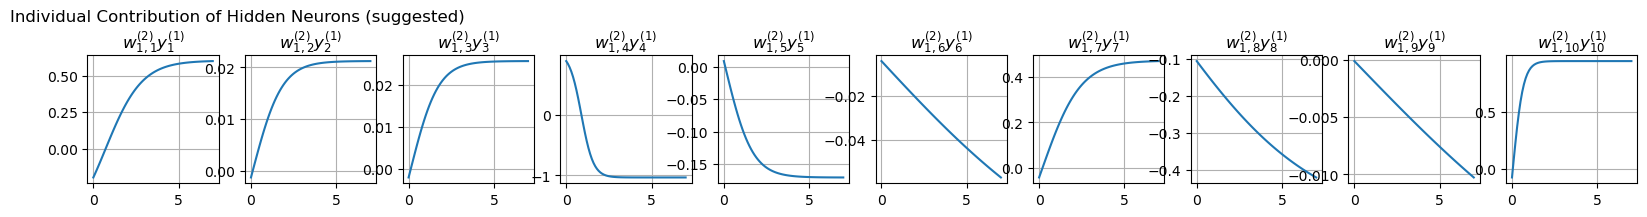

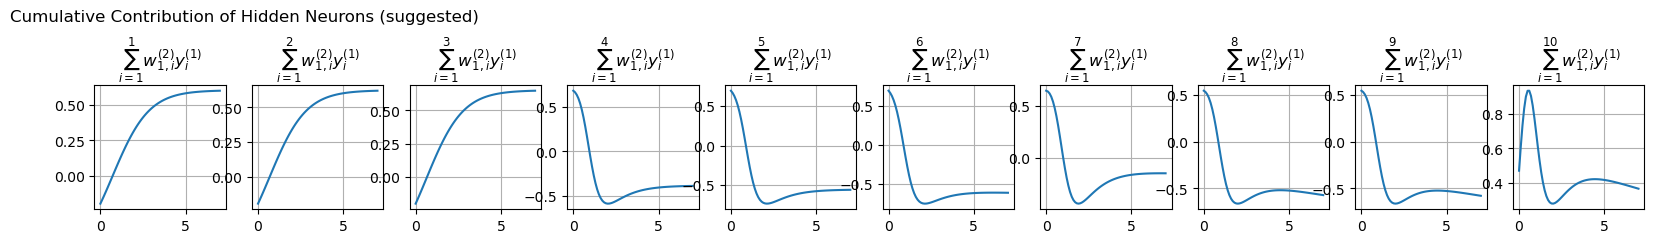

In [6]:
# experiments = [
#   ('expt name 1', num hidden neurons 1, learn rate 100, epochs 1, batch size 1)
#   ('expt name 2', num hidden neurons 2, learn rate 2, epochs 2, batch size 2),
#   ...
# ]
experiments = [
  ('mimimal', 4, 0.01, 7000, 10),
  ('suggested', 10, 0.01, 6500, 10),
]

for expt in experiments:
  r_expt_name = expt[0]
  r_num_hidden = expt[1]
  r_learning_rate = expt[2]
  r_epochs = expt[3]
  r_batch_size = expt[4]

  print(f'====================== START OF EXPT {r_expt_name} ====================================')

  makeReproducible()
  r_model = rBuildModel()

  makeReproducible()
  r_model, r_history, r_elapsed = rTrainModel()

  r_y_pred = rPredictModel()

  rAnalyzeModel()

  print(f'====================== END OF EXPT {r_expt_name} ======================================')

---
# 4 $\quad$ Download Data
Run the following code to download all figures and data, which can be used in the report.

In [ ]:
# !rm -rf data.zip
# !zip -r data.zip data
# files.download('data.zip')



---
# 5 $\quad$ Submission Requirements
1. Complete Sections 1 and 2.
2. In Section 3, submit the worksheet by specifying **only** the following two experiments and their hyperparameters:
```python
  experiment = [
    ('minimal', ???), # ??? the other hyperparamters
    ('suggested', ???), # ??? the other hyperparameters
  ]
```
  1. For the `minimal` experiment, specify the best set hyperparameters to design a network that uses the minimal number of hidden neurons. Change only the number of hidden neurons, the epochs, and the learning rate. The minimal number is the number of changing slope directions until the steady-state. The number of epochs must be less than 10,000. Keep the batch size as 10.

  2. For the `suggested` experiment, specify the best set of hyperparameters for a network that has minimal loss over the measured output. Change only the number of hidden neurons, the epochs, and the learning rate. The number of epochs must be less than 10,000, and the number of hidden neurons must be less than three times the minimal number. Keep the batch size as 10.

3. Justify your choice for the `minimal` experiment in the box below, by discussing with respect to the activation function and their individual and cumulative contributions.

4. Justify your choice for the `suggested` experiment in the box below, by discussing with respect to over-fitting, training time, loss, and the number of weights (trainable parameters).

5. **Do not indicate your name anywhere in the file**.

6. Rename this file as `L1_<MATRIC>.ipynb` where `<MATRIC>` is your matric in **CAPITAL LETTERS**. For example, `L1_A0123456X.ipynb`, and submit to Canvas `L1` assignment.


**Answer Q3 here (double click this)**

Tuning the hyperparameters for the minimal experiment was primarily based on the number of changing slode directions.Basing it visually, there appears to about 4.5-ish changing slope directions. For simplicity, I approximated it to 5 and set number of hidden neurons was set to 5 as a result. The activation function used was the TanH function. It is a good activation function for hidden layers as it is zero-centered, which helps in the convergence of the model. The TanH functions([-1,1]) also have a steeper gradient compared to the sigmoid function([0,1]), which helps in the convergence of the model. Since this model is a relatively simple model, the TanH function will be viable as we do not need to worry about the vanishing gradient problem too. From the individual contributions, I observed that the 5 neurons were contributing to the 5 changing slope directions. The cumulative contributions of the 5 neurons were able to approximate the response of the system well too. To be honest, when experimenting with 3 and 4 neurons, the model was  able to approximate the response of the system pretty well too. However, the loss was slightly higher than the model with 5 neurons. Hence, I decided to go with 5 neurons for the minimal experiment.

**Answer Q4 here (double click this)**
Firstly, I decided that I should find the optimal number of hidden neurons for the model before playing with the learning rate and epochs. After incrementing and comparing, I notice that after hitting 11 hidden neurons, the model apears to worsen. To verify I compared with varying epochs at the 8-12 hidden nuerons range and ultimately found that 10 was the most ideal in terms of loss and following to the true curve. However, when playing with the learning rate, I found a smaller learning rate yielded better quality in terms of minimizing loss. This is understanbable as a lower learning rate will result in more likelihood of reaching the minima for loss. Graphically, when the learning rate was 0.1, the moving average was too noisy as compared to 0.01 which indicates that the learning was too high and that the model is struggling to find a smooth gradient descent. However, I found 0.01 to be the ideal value as going any lower will result in a requiring more than 10000 epochs. Hence, I decided to go with 10 hidden neurons, 0.01 learning rate and 7000 epochs for the suggested experiment. Since there 10 hidden nuerons and one output nuerons, we will have 10*1 + 1 = 11 weights. In my opinion, as this is a relatively easy curve to approximate, there may be varying ways to approximate the curve. Applying this to a real world context situation where we might often not know the true curve, the model with 10 hidden neurons, 0.01 learning rate and 7000 epochs was what I found to be the best in this scenario.